# LightGBM in `sklearn`

In [168]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os
from plotnine import *

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn import config_context

config_context(transform_output="pandas")

In [156]:
# import data
dt_train = pd.read_csv("train.csv").astype({"children":"category"})
dt_test = pd.read_csv("test.csv").astype({"children":"category"})

dt_train.head(3)

,age,sex,bmi,children,smoker,region,charges
0,61,female,25.08,0,no,southeast,24513.09126
1,41,male,29.64,5,no,northeast,9222.40260
2,25,male,26.22,0,no,northeast,2721.32080


In [17]:
X_train, y_train = dt_train.drop("charges", axis=1), dt_train["charges"]
X_test, y_test = dt_test.drop("charges", axis=1), dt_test["charges"]

In [157]:
# Convert objects to categories
for dataset in [X_train, X_test]:
    for col in dataset.select_dtypes(include="object").columns:
        dataset[col] = dataset[col].astype("category")

In [158]:
# Check if it has worked:
for dataset in [X_train, X_test]:
    print(dataset.dtypes)
    print("------------------------------")

age            int64
sex         category
bmi          float64
children    category
smoker      category
region      category
dtype: object
------------------------------
age            int64
sex         category
bmi          float64
children    category
smoker      category
region      category
dtype: object
------------------------------


### Pipeline:

In [159]:
# Specify numerical and categorical columns for preprocessing:
num_cols = X_train.select_dtypes(include=[np.number]).columns
cat_cols = [x for x in X_train.columns if x not in num_cols]

No missing values, only need to scale and onehot encode:

In [170]:
# Making pipelines for column transformer
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder()),
])

# Making column transformer
preprocessor = ColumnTransformer(
    transformers=[("numeric", numeric_transformer, num_cols),
                  ("categorical", categorical_transformer, cat_cols)]
)

# Making model pipeline for lightgbm
lgbm_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("LGBMmodel", LGBMRegressor())
])

xg_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("XGmodel", XGBRegressor())
])


See transformed dataset:

In [172]:
pd.DataFrame(preprocessor.fit_transform(X_train, y_train),
             columns=xg_pipeline[:-1].get_feature_names_out())


,numeric__age,numeric__bmi,categorical__sex_female,categorical__sex_male,categorical__children_0,categorical__children_1,categorical__children_2,categorical__children_3,categorical__children_4,categorical__children_5,categorical__smoker_no,categorical__smoker_yes,categorical__region_northeast,categorical__region_northwest,categorical__region_southeast,categorical__region_southwest
0,1.563678,-0.919141,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.137564,-0.167432,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,-1.003328,-0.731214,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,-1.288551,-0.543287,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.208870,-0.619117,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,1.278455,1.601392,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
999,-1.359856,-1.426874,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1000,-1.502468,-1.626341,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1001,0.280175,-0.621590,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


Skip hyperparameter tuning, just fit like XGBoost:

In [173]:
lgbm_fit = lgbm_pipeline.fit(X_train, y_train) 

In [174]:
xg_fit = xg_pipeline.fit(X_train, y_train) 

In [176]:
# Print the metrics for LGBM
print(f"R-Squared: {r2_score(y_pred=lgbm_fit.predict(X_test), y_true=y_test)}")
print(f"MAE: {mean_absolute_error(y_pred=lgbm_fit.predict(X_test), y_true=y_test)}")
print(f"MAPE: {mean_absolute_percentage_error(y_pred=lgbm_fit.predict(X_test), y_true=y_test)}")

R-Squared: 0.865443414932083
MAE: 2555.8266870148336
MAPE: 0.3251270993504258


In [175]:
# Print the metrics for XGB
print(f"R-Squared: {r2_score(y_pred=xg_fit.predict(X_test), y_true=y_test)}")
print(f"MAE: {mean_absolute_error(y_pred=xg_fit.predict(X_test), y_true=y_test)}")
print(f"MAPE: {mean_absolute_percentage_error(y_pred=xg_fit.predict(X_test), y_true=y_test)}")

R-Squared: 0.8334400636802267
MAE: 2975.6526215350104
MAPE: 0.3859308347476868


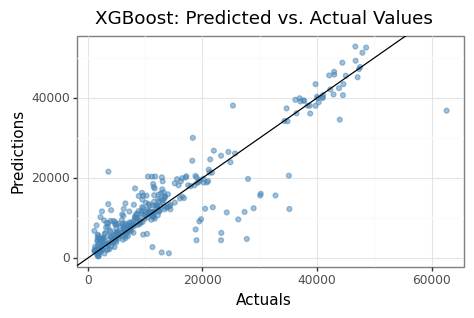

<ggplot: (153774047169)>

In [177]:
predictions = pd.DataFrame(
    {"predictions": xg_fit.predict(X_test), "truth": y_test})

p = (ggplot(data=predictions, mapping=aes(x="truth", y="predictions")) +
    geom_point(colour="#4584b6", alpha=0.5) +
    geom_abline() +
    labs(title="XGBoost: Predicted vs. Actual Values",
         y="Predictions", x="Actuals") +
    theme_bw() +
    theme(figure_size=[5, 3])
)

p

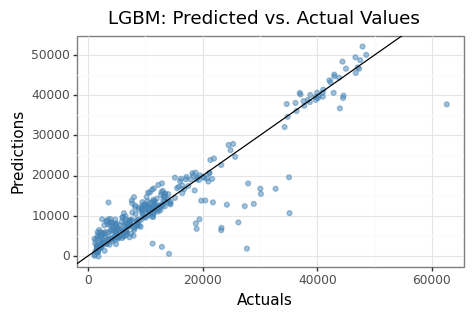

<ggplot: (153777658304)>

In [179]:
predictions = pd.DataFrame(
    {"predictions": lgbm_fit.predict(X_test), "truth": y_test})

p = (ggplot(data=predictions, mapping=aes(x="truth", y="predictions")) +
    geom_point(colour="#4584b6", alpha=0.5) +
    geom_abline() +
    labs(title="LGBM: Predicted vs. Actual Values",
         y="Predictions", x="Actuals") +
    theme_bw() +
    theme(figure_size=[5, 3])
)

p